In [23]:
## Necessary Modules and Libraries Imports ##
import numpy as np 
import pandas as pd
import os
import random
import plotly
import sklearn as sk
import matplotlib.pyplot as mpp
import seaborn as sb
import geopy.distance   ##To find distance from givem cordinates ##
from scipy.stats import pearsonr ## To find Pearson Correlation ##
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
print(os.listdir("../input"))

['GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv', 'test.csv']


In [24]:
## Taking a random sample of 1,000,000 records from train.csv##
data = "../input/train.csv"
n = sum(1 for line in open(data)) - 1 ##-1 for removing header ##
sample_size = 1000000
skip = sorted(random.sample(range(1,n+1), n-sample_size))
train_sample =  pd.read_csv(data, skiprows = skip)

In [ ]:
## Checking how many null values exist in the dataset ##
train_sample.isnull().sum()

In [9]:
train_sample.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-12-06 09:09:21.0000007,9.7,2011-12-06 09:09:21,-73.985582,40.739765,-73.973899,40.760426,1
1,2014-07-20 12:48:35.0000001,17.0,2014-07-20 12:48:35,-73.973390,40.743883,-73.954021,40.766063,1
2,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21,-73.974938,40.762091,-74.003309,40.706195,2
3,2010-05-25 20:14:00.000000130,6.1,2010-05-25 20:14:00,-74.005278,40.735298,-73.986698,40.729892,1
4,2014-07-20 23:51:54.0000003,12.0,2014-07-20 23:51:54,-73.984997,40.768466,-73.944564,40.800466,1


In [7]:
train_sample.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,977141.00000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000
mean,11.33947,-73.900378,40.713260,-73.905908,40.716411,1.690898
std,9.74365,2.351535,1.236283,2.248995,1.189428,1.307331
min,2.50000,-89.583332,-0.563333,-93.216667,0.000000,1.000000
25%,6.00000,-73.992290,40.736420,-73.991579,40.735399,1.000000
50%,8.50000,-73.982089,40.753302,-73.980602,40.753781,1.000000
75%,12.50000,-73.968237,40.767470,-73.965281,40.768355,2.000000
max,499.00000,0.000000,73.997880,0.000000,73.979653,6.000000


In [25]:
## Removing rows with Null values in any column, because we found only 14 rows with Null values out of ##
## out of 1Million rows ##
train_sample = train_sample.dropna(how = 'any', axis = 'rows')

In [26]:
## Taking Test Data in the dataframe ##
test_full = pd.read_csv('../input/test.csv')

In [36]:
## Data Cleaning Steps - for Training Data ##


## 1. Since number of passengers can't be zero and fare amount will be atleast $2.5, drop such rows.
## Ref: http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml#3 ##
train_sample = train_sample[train_sample.fare_amount>=2.5]
train_sample = train_sample[(train_sample.passenger_count > 0) & (train_sample.passenger_count <=6)]

## 2. Removing latitudes and longitudes which lies out of range where latitudes range from -90 to 90 and
## longitudes range from -180 to 180.
train_sample = train_sample[(train_sample.pickup_longitude>=-180) & (train_sample.pickup_longitude<=180)]
train_sample = train_sample[(train_sample.dropoff_longitude>=-180) & (train_sample.dropoff_longitude<=180)]
train_sample = train_sample[(train_sample.pickup_latitude>=-90) & (train_sample.pickup_latitude<=90)]
train_sample = train_sample[(train_sample.dropoff_latitude>=-90) & (train_sample.dropoff_latitude<=90)]

## 3. Converting datatype of pickup_datetime from object type to datetime Datatype for further processing.
train_sample['pickup_datetime'] = pd.to_datetime(train_sample['pickup_datetime'])

## 4. We want the rows which have either their pickup or drop-off within the boundary of NYC. ##
## We identify boundaries of NYC as latitude = [40,42] & longitude = [-75,-72]##
## Ref: https://www.mapdevelopers.com/geocode_bounding_box.php##
train_sample = train_sample[ ((train_sample['pickup_latitude']>=40) & (train_sample['pickup_latitude']<=42)) | ((train_sample['dropoff_latitude']>=40) & (train_sample['dropoff_latitude']<=42))]
train_sample = train_sample[ ((train_sample['dropoff_longitude']>=-75) & (train_sample['dropoff_longitude']<=-72)) | ((train_sample['pickup_longitude']>=-75) & (train_sample['pickup_longitude']<=-72))]

## 5. Finding if there are any missing values in a column? If yes, removing it since there number is very negligible. ##
train_sample.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
Year                 0
Month                0
Date                 0
Day                  0
Season               0
Distance_Miles       0
UTC_Hour             0
ET_Hour              0
TimeOfDay            0
dtype: int64

In [21]:
## Viewing stats about the training sample data ##
train_sample.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Date,Day,Season,Distance_Miles,UTC_Hour,ET_Hour,Year
count,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000,975122.000000
mean,11.331030,-73.975467,40.750768,-73.974559,40.751112,1.690980,6.260239,15.713466,3.038968,2.451543,2.081782,13.506898,11.826763,2011.739448
std,9.718289,0.037321,0.029330,0.036361,0.032870,1.307381,3.436595,8.685086,1.950191,1.101202,2.539890,6.511535,5.831420,1.865716
min,2.500000,-75.460542,39.602783,-75.465493,39.383896,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2009.000000
25%,6.000000,-73.992300,40.736492,-73.991590,40.735480,1.000000,3.000000,8.000000,1.000000,1.000000,0.780734,9.000000,7.000000,2010.000000
50%,8.500000,-73.982102,40.753334,-73.980622,40.753811,1.000000,6.000000,16.000000,3.000000,2.000000,1.339252,14.000000,12.000000,2012.000000
75%,12.500000,-73.968308,40.767490,-73.965368,40.768366,2.000000,9.000000,23.000000,5.000000,3.000000,2.430270,19.000000,17.000000,2013.000000
max,499.000000,-72.993717,41.366138,-72.416667,41.433332,6.000000,12.000000,31.000000,6.000000,4.000000,97.228576,23.000000,23.000000,2015.000000


In [22]:
## Number of rows remaining after data cleaning ##
print(train_sample.shape[0])

975122


In [28]:
## Functions for pre-proceesing of the training sample data.

## 1. Adding a column of Season in NYC. Since, there may be more car rides in extreme winter or extreme summer
## Reference: https://www.nyc.com/visitor_guide/weather_facts.75835/ ##
def seasonNYC(month):
    if month in [12,1,2]:
        return 1 ##Winter
    if month in [3,4,5]:
        return 2  ##Spring
    if month in [6,7,8]:
        return 3 ##Summer
    if month in [9,10,11]:
        return 4 ##Fall

## 2. Converting UTC to EDT and EST. Assuming that EST is valid from Nov-Feb amd EDT is valid from Mar-Oct ##
def UTC2ET(hour, month):
    if month in [11,12,1,2]:
        hour = hour - 5 ##EST
    else:
        hour = hour - 4 ##EDT
    if (hour<0):
        return hour+24
    else:
        return hour
    
## 3. Calculating vincenty distance from given longitude and latitude cordinates
def vincentyDist(lat1, lat2, lon1, lon2):
    try:
        loc1 = (lat1, lon1)
        loc2 = (lat2, lon2)
        dist = geopy.distance.vincenty(loc1, loc2).miles
        return dist
    except:
        return None
    
## 4. Categorizing hour of day into time of day ##
def timeOfDay(hour):
    if hour in [0,1,2,3,4]:
        return 0  ##Midnight
    if hour in [4,5,6]:
        return 1  ##Dawn
    if hour in [7,8,9,10,11]:
        return 2 ##Morning
    if hour in [12,13,14,15]:
        return 3 ##Afternoon
    if hour in [16,17,18,19]:
        return 4 ##Evening
    if hour in [20,21,22,23]:
        return 5 ##Night

In [ ]:
## Distribution of Fare Amount in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['fare_amount']);
mpp.title('Distribution of Fare Amount ($)');

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



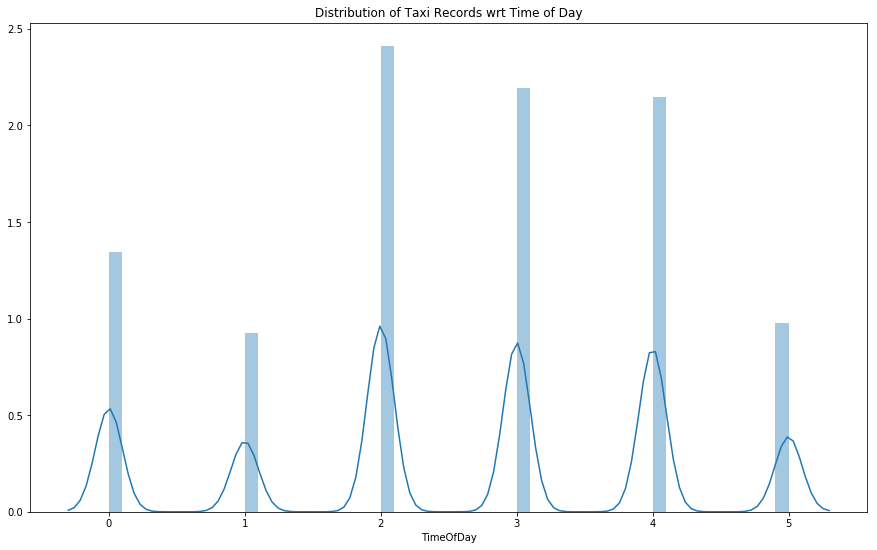

In [54]:
## Distribution of Time of Day in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['TimeOfDay']);
mpp.title('Distribution of Taxi Records wrt Time of Day');

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



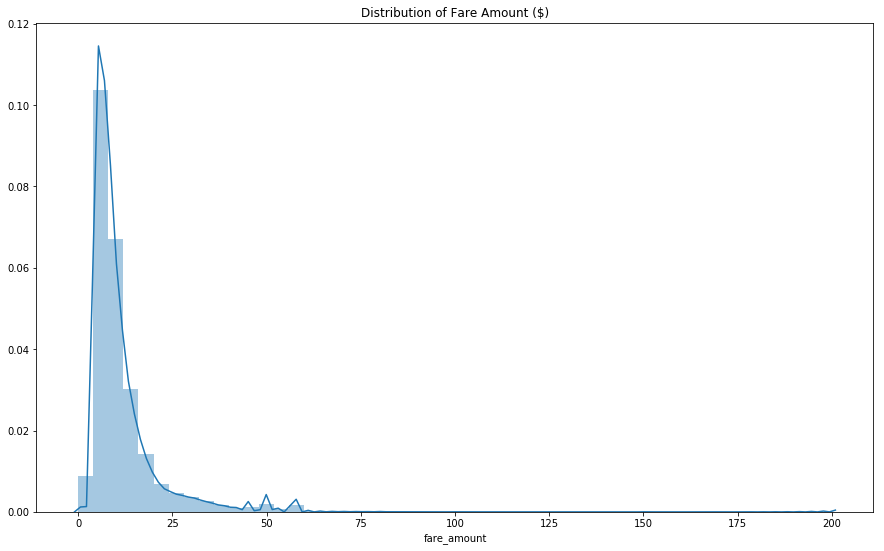

In [29]:
## There are definitely some outliers wrt fare amount. Based upon my intuition, the fares should not be higher that $200. ##
train_sample = train_sample[train_sample['fare_amount']<=200]
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['fare_amount']);
mpp.title('Distribution of Fare Amount ($)');

In [ ]:
## Distribution of Pickup Latitude in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['pickup_latitude']);
mpp.title('Distribution of Pickup Latitude');

In [ ]:
## Distribution of Pickup Longotude in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['pickup_longitude']);
mpp.title('Distribution of Pickup Longitude');

In [ ]:
## Distribution of Drop Off Latitude in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['dropoff_latitude']);
mpp.title('Distribution of Dropoff Latitude');

In [ ]:
## Distribution of DropOff Longitude in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['dropoff_longitude']);
mpp.title('Distribution of Dropoff Longitude');

In [ ]:
## Distribution of Passenger Count in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['passenger_count']);
mpp.title('Distribution of Passenger Count');

In [30]:
## Final Data Pre-processing Steps - for Training Data ##
train_sample['Year'] = train_sample['pickup_datetime'].dt.year
train_sample['Month'] = train_sample['pickup_datetime'].dt.month
train_sample['Date'] = train_sample['pickup_datetime'].dt.day
train_sample['Day'] = train_sample['pickup_datetime'].dt.dayofweek ## Monday=0, Sunday=6
train_sample['Season'] = train_sample.apply(lambda row: seasonNYC(row.Month),axis=1)
train_sample['Distance_Miles'] = train_sample.apply(lambda row: vincentyDist(row.pickup_latitude,row.dropoff_latitude,row.pickup_longitude,row.dropoff_longitude),axis=1)
train_sample['UTC_Hour'] = train_sample['pickup_datetime'].dt.hour
train_sample['ET_Hour'] = train_sample.apply(lambda row: UTC2ET(row.UTC_Hour, row.Month),axis=1)
train_sample['TimeOfDay'] = train_sample.apply(lambda row: timeOfDay(row.ET_Hour),axis=1)

In [13]:
train_sample.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Date,Day,Season,Distance_Miles,UTC_Hour,ET_Hour,Year
count,977141.00000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000,977141.000000
mean,11.33947,-73.900378,40.713260,-73.905908,40.716411,1.690898,6.260031,15.712638,3.038786,2.451461,12.349340,13.507178,11.826610,2011.741636
std,9.74365,2.351535,1.236283,2.248995,1.189428,1.307331,3.436507,8.684966,1.950139,1.101160,230.645544,6.511418,5.831426,1.865805
min,2.50000,-89.583332,-0.563333,-93.216667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2009.000000
25%,6.00000,-73.992290,40.736420,-73.991579,40.735399,1.000000,3.000000,8.000000,1.000000,1.000000,0.781744,9.000000,7.000000,2010.000000
50%,8.50000,-73.982089,40.753302,-73.980602,40.753781,1.000000,6.000000,16.000000,3.000000,2.000000,1.342089,14.000000,12.000000,2012.000000
75%,12.50000,-73.968237,40.767470,-73.965281,40.768355,2.000000,9.000000,23.000000,5.000000,3.000000,2.441438,19.000000,17.000000,2013.000000
max,499.00000,0.000000,73.997880,0.000000,73.979653,6.000000,12.000000,31.000000,6.000000,4.000000,5399.401228,23.000000,23.000000,2015.000000


In [ ]:
train_sample.head()

In [ ]:
## Distribution of different Season's in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['Season']);
mpp.xlabel("Seasons (Winter-1, Spring-2, Summer-3, Fall-4)")
mpp.title('Distribution of rides Season-Wise in NYC');

In [ ]:
## Distribution of Monthwise Taxi Rides in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['Month']);
mpp.title('Distribution of Monthwise Taxi Rides in NYC');

In [ ]:
## Distribution of Day-wise Taxi Rides in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['Day']);
mpp.title('Distribution of Day-wise Taxi Rides in NYC');

In [ ]:
## Distribution of Hour-wise Taxi Rides in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['ET_Hour']);
mpp.xlabel("Time of Day (0-24Hrs, Eastern Time) ")
mpp.title('Distribution of Time of Day wise Taxi Rides in NYC');

In [ ]:
## Distribution of Distance travelled by Taxi Rides in the given dataset ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['Distance_Miles']);
mpp.title('Distribution of Distance Travelled (miles)');

In [ ]:
## Keeping rows with distance only till 300 miles and trying to detect outliers based upon the previous visualization ##
train_sample = train_sample[train_sample['Distance_Miles']<=300]

In [ ]:
## Distribution of Distance travelled by Taxi Rides with distance <=300 Miles ##
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['Distance_Miles']);
mpp.title('Distribution of Distance Travelled (miles)');

In [ ]:
################################## Final Cleaned Data Cut-Offs ###################################

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



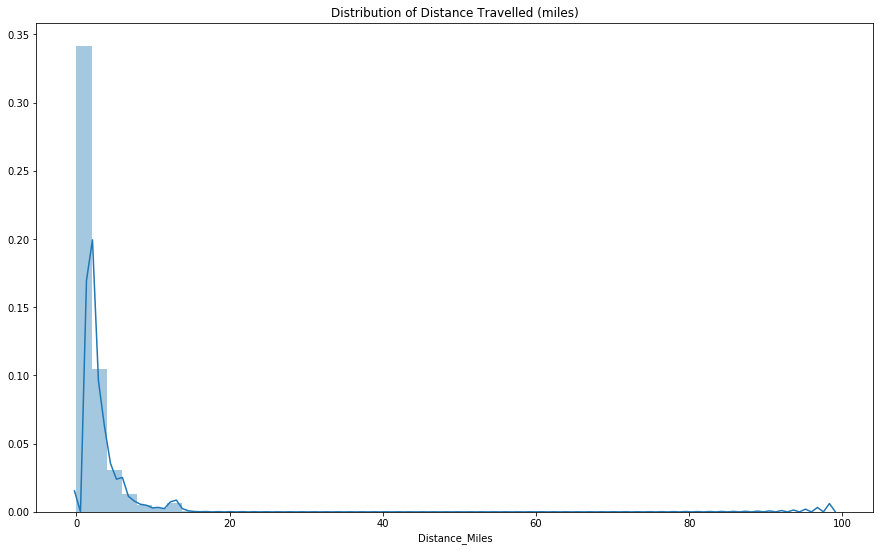

In [32]:
## Keeping rows with distance only till 100 miles based upon the visualization seen above ##
train_sample = train_sample[train_sample['Distance_Miles']<=100]
mpp.figure(figsize = (15, 9))
sb.distplot(train_sample['Distance_Miles']);
mpp.title('Distribution of Distance Travelled (miles)');

In [ ]:
print ("Currently rows are: ",train_sample.shape[0])

In [ ]:
train_sample.head()

In [33]:
## Processing Test Data on similar lines as Training Data ##

test_full['pickup_datetime'] = pd.to_datetime(test_full['pickup_datetime'])
test_full['Year'] = test_full['pickup_datetime'].dt.year
test_full['Month'] = test_full['pickup_datetime'].dt.month
test_full['Date'] = test_full['pickup_datetime'].dt.day
test_full['Day'] = test_full['pickup_datetime'].dt.dayofweek ## Monday=0, Sunday=6
test_full['Season'] = test_full.apply(lambda row: seasonNYC(row.Month),axis=1)
test_full = test_full[(test_full.pickup_longitude>=-180) & (test_full.dropoff_longitude<=180)]
test_full = test_full[(test_full.pickup_latitude>=-90) & (test_full.dropoff_latitude<=90)]
test_full['Distance_Miles'] = test_full.apply(lambda row: vincentyDist(row.pickup_latitude,row.dropoff_latitude,row.pickup_longitude,row.dropoff_longitude),axis=1)
test_full['UTC_Hour'] = test_full['pickup_datetime'].dt.hour
test_full['ET_Hour'] = test_full.apply(lambda row: UTC2ET(row.UTC_Hour, row.Month),axis=1)
test_full['TimeOfDay'] = test_full.apply(lambda row: timeOfDay(row.ET_Hour),axis=1)
test_full.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day,Season,Distance_Miles,UTC_Hour,ET_Hour,TimeOfDay
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,1,1.442197,13,8,2
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,1,1.506080,13,8,2
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,5,4,0.384120,11,7,2
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,5,1,1.217683,21,16,4
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,5,1,3.344737,21,16,4


In [37]:
## Finding Pearson Correlations ##
print ("Pearson Correlation Between Distance and Fare: ", pearsonr(train_sample['Distance_Miles'], train_sample['fare_amount'])[0])
print ("Pearson Correlation Between Time of the day (Hour) and Distance: ", pearsonr(train_sample['Distance_Miles'], train_sample['ET_Hour'])[0])
print ("Pearson Correlation Between Time of the day (Hour) and Taxi Fare: ", pearsonr(train_sample['ET_Hour'], train_sample['fare_amount'])[0])

Pearson Correlation Between Distance and Fare:  0.7636914009080217
Pearson Correlation Between Time of the day (Hour) and Distance:  0.02912279744224581
Pearson Correlation Between Time of the day (Hour) and Taxi Fare:  -0.00392983960140738


In [38]:
## Finding Pearson Correlations ##
print ("Pearson Correlation Between Day of the Week and Taxi Fare: ", pearsonr(train_sample['Day'], train_sample['fare_amount'])[0])
print ("Pearson Correlation Between Month and Taxi Fare: ", pearsonr(train_sample['Month'], train_sample['fare_amount'])[0])
print ("Pearson Correlation Between Season and Taxi Fare: ", pearsonr(train_sample['Season'], train_sample['fare_amount'])[0])
print ("Pearson Correlation Between Season and Passenger: ", pearsonr(train_sample['Season'], train_sample['passenger_count'])[0])
print ("Pearson Correlation Between Month and Passenger: ", pearsonr(train_sample['Month'], train_sample['passenger_count'])[0])
print ("Pearson Correlation Between Day of the Week and Passenger: ", pearsonr(train_sample['Day'], train_sample['passenger_count'])[0])
print ("Pearson Correlation Between Number of Passengers and Taxi Fare: ", pearsonr(train_sample['passenger_count'], train_sample['fare_amount'])[0])
print ("Pearson Correlation Between Year and Taxi Fare: ", pearsonr(train_sample['Year'], train_sample['fare_amount'])[0])
print ("Pearson Correlation Between Year and Distance: ", pearsonr(train_sample['Year'], train_sample['Distance_Miles'])[0])

Pearson Correlation Between Day of the Week and Taxi Fare:  0.0025936360564554877
Pearson Correlation Between Month and Taxi Fare:  0.025472902600251094
Pearson Correlation Between Season and Taxi Fare:  0.020925899063913945
Pearson Correlation Between Season and Passenger:  -0.0013606182222007756
Pearson Correlation Between Month and Passenger:  0.00538040674337481
Pearson Correlation Between Day of the Week and Passenger:  0.03415099572973471
Pearson Correlation Between Number of Passengers and Taxi Fare:  0.012443464250460643
Pearson Correlation Between Year and Taxi Fare:  0.11617543288466378
Pearson Correlation Between Year and Distance:  0.01619744138289539


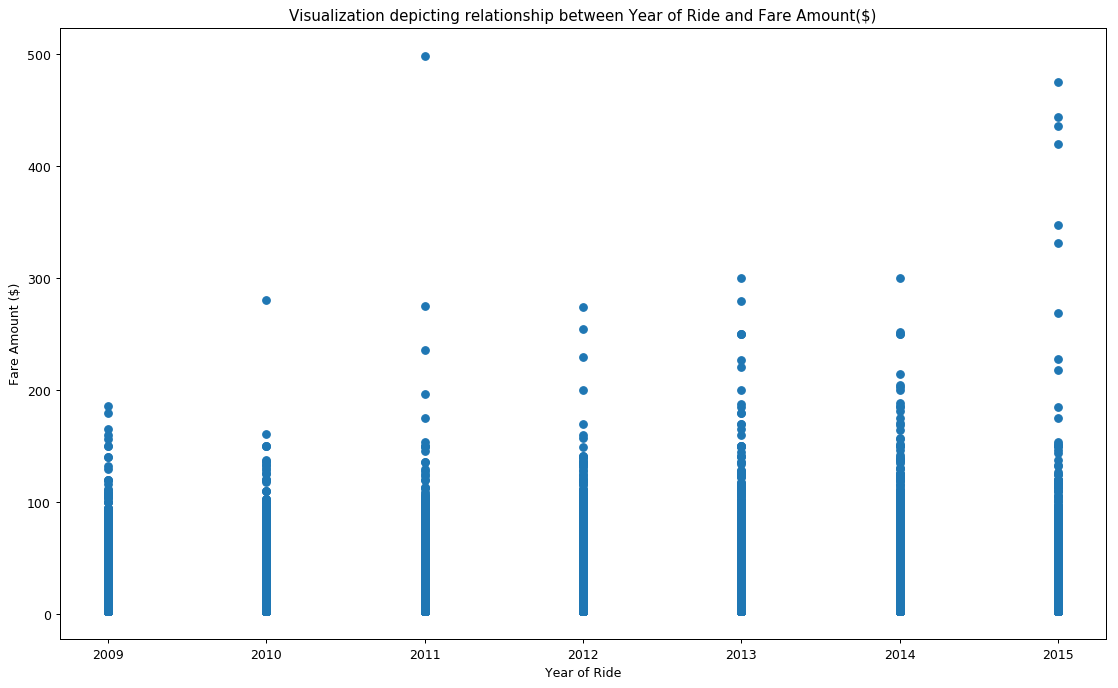

In [17]:
## Graph to visualize relationship between year and taxi fare ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Year of Ride and Fare Amount($)")
mpp.xlabel("Year of Ride")
mpp.ylabel("Fare Amount ($)")
mpp.scatter(train_sample['Year'],train_sample['fare_amount'])
mpp.show()

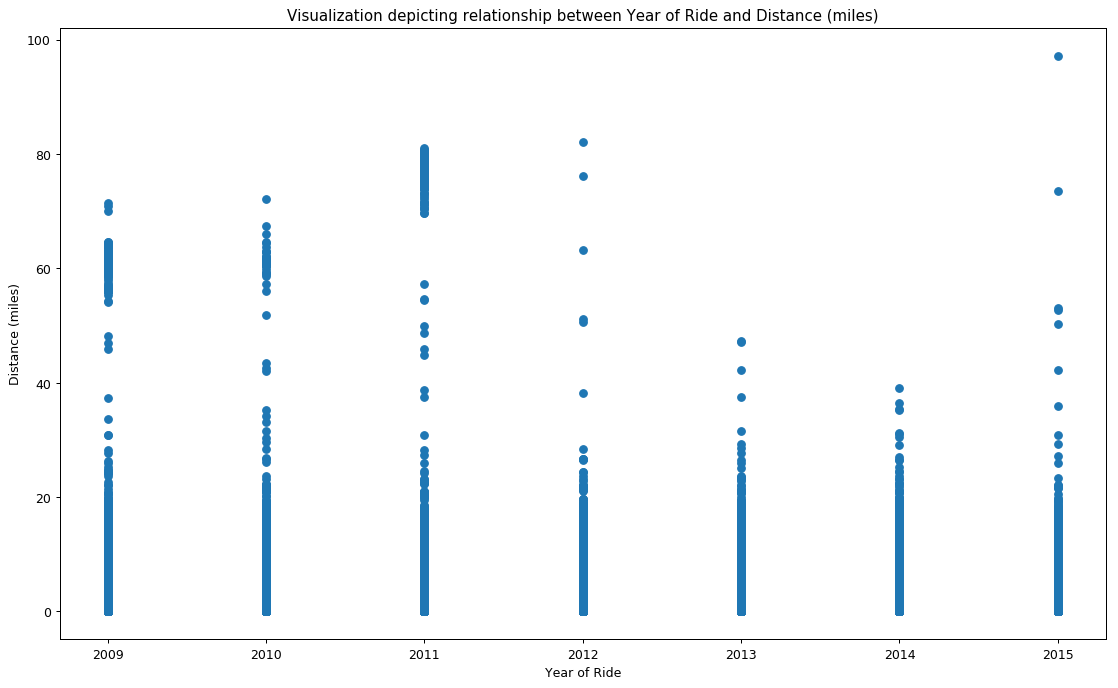

In [18]:
## Graph to visualize relationship between year and ditance ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Year of Ride and Distance (miles)")
mpp.xlabel("Year of Ride")
mpp.ylabel("Distance (miles)")
mpp.scatter(train_sample['Year'],train_sample['Distance_Miles'])
mpp.show()

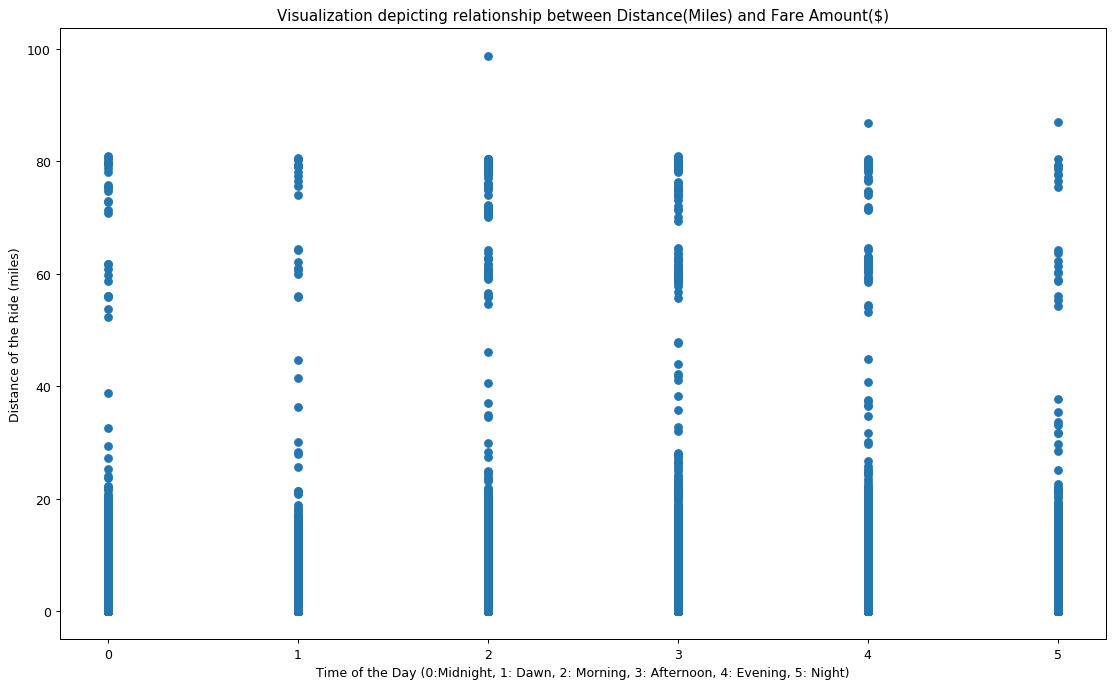

In [55]:
## Graph to visualize relationship between Distance of the ride and Time of the Day ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Distance(Miles) and Time of the Day")
mpp.xlabel("Time of the Day (0:Midnight, 1: Dawn, 2: Morning, 3: Afternoon, 4: Evening, 5: Night)")
mpp.ylabel("Distance of the Ride (miles)")
mpp.scatter(train_sample['TimeOfDay'],train_sample['Distance_Miles'])
mpp.show()

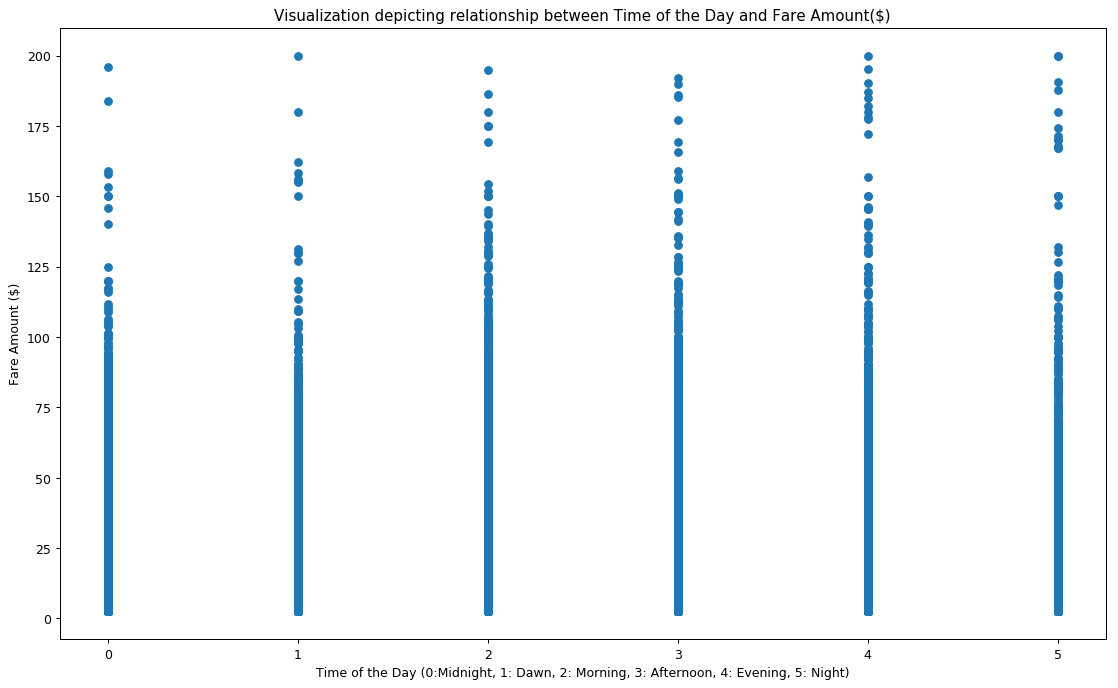

In [57]:
## Graph to visualize relationship between Fare Amount and Time of the Day ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Time of the Day and Fare Amount($)")
mpp.xlabel("Time of the Day (0:Midnight, 1: Dawn, 2: Morning, 3: Afternoon, 4: Evening, 5: Night)")
mpp.ylabel("Fare Amount ($)")
mpp.scatter(train_sample['TimeOfDay'],train_sample['fare_amount'])
mpp.show()

In [ ]:
## Graph to visualize relationship between Distance of the ride and taxi fare ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Distance(Miles) and Fare Amount($)")
mpp.xlabel("Distance of the Ride (miles)")
mpp.ylabel("Fare Amount ($)")
mpp.scatter(train_sample['Distance_Miles'],train_sample['fare_amount'])
mpp.show()

In [ ]:
## Graph to visualize relationship between Hour of the day and taxi fare ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Time of the Day (Eastern Time) and Distance(Miles)")
mpp.xlabel("Time of the Day (Eastern Time)")
mpp.ylabel("Distance of the ride (miles)")
mpp.scatter(train_sample['ET_Hour'],train_sample['Distance_Miles'])
mpp.show()

In [ ]:
## Graph to visualize relationship between Distance of the ride and time of the day ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Time of the Day (Eastern Time) and Distance(Miles)")
mpp.ylabel("Time of the Day (Eastern Time)")
mpp.xlabel("Distance of the ride (miles)")
mpp.scatter(train_sample['Distance_Miles'], train_sample['ET_Hour'])
mpp.show()

In [ ]:
## Graph to visualize relationship between Time of the Day and taxi fare ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Time of the Day (Eastern Time) and Fare Amount ($)")
mpp.xlabel("Time of the Day (Easternn Time)")
mpp.ylabel("Fare Amount ($)")
mpp.scatter(train_sample['ET_Hour'],train_sample['fare_amount'])
mpp.show()

In [ ]:
## Graph to visualize relationship between Time of the day and taxi fare ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Time of the Day (Eastern Time) and Fare Amount ($)")
mpp.ylabel("Time of the Day (Eastern Time)")
mpp.xlabel("Fare Amount ($)")
mpp.scatter(train_sample['fare_amount'], train_sample['ET_Hour'])
mpp.show()

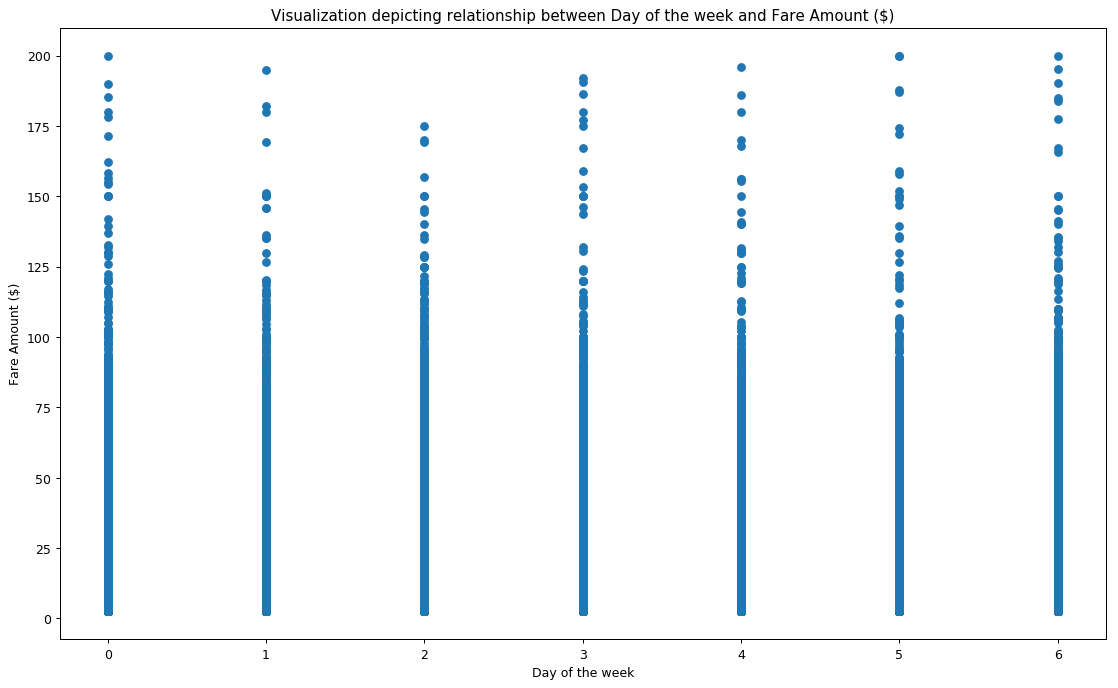

In [58]:
## Graph to visualize relationship between Day of the Week and taxi fare ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Day of the week and Fare Amount ($)")
mpp.xlabel("Day of the week")
mpp.ylabel("Fare Amount ($)")
mpp.scatter(train_sample['Day'], train_sample['fare_amount'])
mpp.show()

In [ ]:
## Graph to visualize relationship between Day of the week and distance ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Day of the week and Distance (miles)")
mpp.xlabel("Day of the week")
mpp.ylabel("Distance (miles)")
mpp.scatter(train_sample['Day'], train_sample['Distance_Miles'])
mpp.show()

In [ ]:
## Graph to visualize relationship between No of Passengers and taxi fare ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Fare Amount ($) and Passenger Count")
mpp.xlabel("Passenger Count")
mpp.ylabel("Fare Amount ($)")
mpp.scatter(train_sample['passenger_count'],train_sample['fare_amount'])
mpp.show()

In [ ]:
## Graph to visualize relationship between Day of the week of the ride and Passenger ##
mpp.figure(figsize=(15, 9), dpi=90)
mpp.title("Visualization depicting relationship between Passenger Count and Day of Week")
mpp.xlabel("Day of Week (Monday - Sunday)")
mpp.ylabel("Passenger Count")
mpp.scatter(train_sample['Day'], train_sample['passenger_count'])
mpp.show()

In [39]:
## Splitting Traing Data in Training and Test Data chunks ##
covariateList = train_sample.drop(['UTC_Hour','pickup_datetime','key','fare_amount'],axis=1)
predList = train_sample['fare_amount']
TrainCov, TestCov , TrainPred, TestPred = train_test_split(covariateList,predList,test_size=0.2,random_state=9)

In [ ]:
## Test Data for Predictions ##
LinRegTest = test_full.drop(['UTC_Hour','pickup_datetime','key'],axis=1

In [40]:
#### Linear Regression Model and Corresponding R^2 Value  ####

linReg = LinearRegression()
linReg.fit(TrainCov, TrainPred)
print("Coefficient of determination R^2 of the prediction for Training Data: ", linReg.score(TrainCov,TrainPred))
print("Coefficient of determination R^2 of the prediction for Test Data: ", linReg.score(TestCov,TestPred))
LinRegPredictions_v1 = linReg.predict(LinRegTest)

## Linear Regression Based Model Prediction Submission File ##
LinRegSubmit = pd.read_csv('../input/sample_submission.csv')
LinRegSubmit['fare_amount'] = LinRegPredictions_v1
LinRegSubmit.to_csv('LinRegSubmit_100k_v8.csv', index=False)

Coefficient of determination R^2 of the prediction for Training Data:  0.6138261444614883
Coefficient of determination R^2 of the prediction for Test Data:  0.6086719061738317


In [43]:
## Calculating Root Mean Square Error for Linear Regression Model ##
FareAmt_Pred_LinReg = linReg.predict(covariateList)
LR_RMSE = np.sqrt(metrics.mean_squared_error(FareAmt_Pred_LinReg, predList))
print("Linear Regression RMSE: ", LR_RMSE)

Linear Regression RMSE:  5.991049097401688


In [45]:
### Coefficients for various co-variates for Linear Regression Model ###
print ( pd.DataFrame(dict(zip(TrainCov.columns,linReg.coef_)),index=[0]).T)

                           0
pickup_longitude   26.773512
pickup_latitude   -13.778373
dropoff_longitude  14.874122
dropoff_latitude  -13.290388
passenger_count     0.055216
Year                0.552254
Month               0.082058
Date                0.001010
Day                -0.022546
Season              0.041587
Distance_Miles      2.610428
ET_Hour            -0.092389
TimeOfDay           0.204865


In [46]:
## Random Forest based Predictive Model (Default Parameters) ##
RForest = RandomForestRegressor()
RForest.fit(TrainCov, TrainPred)
RF_Prediction = RForest.predict(LinRegTest)
print("Random Forest Current Parameters:\n",RForest.get_params())
## Random Forest based Predictive Model (Prediction Submission File) ##
RF_Submit_v1 = pd.read_csv('../input/sample_submission.csv')
RF_Submit_v1['fare_amount'] = RF_Prediction
RF_Submit_v1.to_csv('RF_Submit_100k_v9.csv', index=False)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Random Forest Current Parameters:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [48]:
## Calculating R^2 and RMSE for Random Forest Model (with default parameters)##
FareAmt_Pred = RForest.predict(covariateList)
RF_RMSE = np.sqrt(metrics.mean_squared_error(FareAmt_Pred, predList))
print("Random Forest RMSE: ", RF_RMSE)
print("Coefficient of determination R^2 of the Random Forest prediction for Training Data: ", RForest.score(TrainCov,TrainPred))
print("Coefficient of determination R^2 of the Random Forest prediction for Test Data: ", RForest.score(TestCov,TestPred))

Random Forest RMSE:  2.2679023593763326


In [50]:
### Tuning the Random Forest Based Model (with Model Tuning) ###
## Ref: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 ##
## We will mainly tune the number of trees and the maximum depth of trees, and would see the impact##

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

## Tuning Parameters are:
RF_Tuning = {'n_estimators': [20],   ## No of Trees --> Will check with 5,10,15
               'max_features': max_features,
               'max_depth': [20],    ## Maximum Depth of the trees
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Cross Validation = 3.
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = RF_Tuning, n_iter = 10, cv = 3, verbose=2, random_state=9, n_jobs = -1)
rf_random.fit(covariateList, predList)
FareAmt_Pred_v1 = rf_random.predict(covariateList)
RF_RMSE_v1 = np.sqrt(metrics.mean_squared_error(FareAmt_Pred_v1, predList))
print("Random Forest RMSE: ", RF_RMSE_v1)

## Random Forest based Predictive Model (Prediction Submission File)- Parameter Tuning ##
FareAmt_Pred_v2 = rf_random.predict(LinRegTest)
RF_Submit_v2_Tuned = pd.read_csv('../input/sample_submission.csv')
RF_Submit_v2_Tuned['fare_amount'] = FareAmt_Pred_v2
RF_Submit_v2_Tuned.to_csv('RF_Submit_v2_Tuned_100k_v9.csv', index=False)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 23.9min finished


Random Forest RMSE:  2.6017227196940063


In [ ]:
## KNeighbors based Predictive Model  - Default Parameters##
KNN = KNeighborsRegressor()
KNN.fit(TrainCov, TrainPred)
KNN_Prediction = KNN.predict(LinRegTest)
## KNeighbors Model Submission ##
KNN_Submit_v1 = pd.read_csv('../input/sample_submission.csv')
KNN_Submit_v1['fare_amount'] = KNN_Prediction
KNN_Submit_v1.to_csv('KNN_Submit_100k_v7.csv', index=False)
## Calculating RMSE for KNeighbors Model ##
FareAmt_Pred = KNN.predict(covariateList)
KNN_RMSE = np.sqrt(metrics.mean_squared_error(FareAmt_Pred, predList))
print("KNeighbors Model RMSE: ", KNN_RMSE)
print("Coefficient of determination R^2 of the Random Forest prediction for Training Data: ", KNN.score(TrainCov,TrainPred))
print("Coefficient of determination R^2 of the Random Forest prediction for Test Data: ", KNN.score(TestCov,TestPred))